<a href="https://colab.research.google.com/github/purnatejaTaskani/pneumonia_multimodel/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Kaggle CLI
!pip install -q kaggle

# Upload kaggle.json (API key)
from google.colab import files
files.upload()  # This will open a file picker → select kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"teja19812003","key":"6dcf13fd0a3e149604164d7daae81fa9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/data
!unzip -q /content/data/chest-xray-pneumonia.zip -d /content/data


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:15<00:00, 103MB/s] 
100% 2.29G/2.29G [00:15<00:00, 156MB/s]


In [ ]:
DATA_ROOT = "/content/data/chest_xray/chest_xray"


In [ ]:
import os, csv, uuid

IMAGE_EXTS = {".jpg", ".jpeg", ".png"}

def scan_split(root, split):
    rows = []
    split_dir = os.path.join(root, split)
    for cls in ["NORMAL", "PNEUMONIA"]:
        cls_dir = os.path.join(split_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        for fname in os.listdir(cls_dir):
            ext = os.path.splitext(fname)[1].lower()
            if ext in IMAGE_EXTS:
                path = os.path.join(cls_dir, fname)
                rows.append({
                    "patient_id": str(uuid.uuid4()),
                    "image_path": path,
                    "label": cls,
                    "split": split
                })
    return rows

all_rows = []
for split in ["train", "val", "test"]:
    all_rows.extend(scan_split(DATA_ROOT, split))

with open("images.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["patient_id","image_path","label","split"])
    writer.writeheader()
    writer.writerows(all_rows)

print(f" Created images.csv with {len(all_rows)} rows")


✅ Created images.csv with 5856 rows


In [ ]:
import csv, random, math

def clip(x, lo, hi): return max(lo, min(hi, x))
def bernoulli(p): return int(random.random() < p)
def normal(mu, sigma): return random.gauss(mu, sigma)

def generate_patient(row):
    lab = row["label"]

    age = int(clip(normal(50, 18), 1, 95))
    bmi = round(clip(normal(25, 5), 14, 45), 1)
    smoker = bernoulli(0.25)

    # pneumonia shifts vitals
    if lab == "PNEUMONIA":
        spo2 = int(clip(normal(90, 3.0), 75, 99))
        resp_rate = int(clip(normal(24, 5.0), 12, 40))
        temp_c = round(clip(normal(38.3, 0.7), 36.0, 41.0), 1)
        hr = int(clip(normal(100, 15), 50, 160))
    else:
        spo2 = int(clip(normal(97, 1.5), 92, 100))
        resp_rate = int(clip(normal(16, 2.5), 10, 28))
        temp_c = round(clip(normal(36.8, 0.4), 35.8, 38.5), 1)
        hr = int(clip(normal(78, 12), 45, 140))

    # simple risk
    risk = 0.3*(100-spo2)/25 + 0.2*(resp_rate-12)/28 + 0.15*(temp_c-36)/5 + 0.15*(hr-60)/90
    risk += 0.05*(age/100) + 0.05*(bmi/40) + 0.05*smoker
    if lab=="PNEUMONIA": risk += 0.08
    risk_score = int(clip(risk*100,0,100))

    if risk_score >= 67: severity = 2
    elif risk_score >= 34: severity = 1
    else: severity = 0

    return {
        "patient_id": row["patient_id"],
        "split": row["split"],
        "label": lab,
        "age": age,
        "bmi": bmi,
        "spo2": spo2,
        "resp_rate": resp_rate,
        "heart_rate": hr,
        "temp_c": temp_c,
        "smoker": smoker,
        "risk_score": risk_score,
        "severity_label": severity
    }

# read image manifest
rows = []
with open("images.csv", newline="", encoding="utf-8") as f:
    rdr = csv.DictReader(f)
    for r in rdr:
        rows.append(r)

patients = [generate_patient(r) for r in rows]

with open("patient_data.csv","w",newline="",encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=list(patients[0].keys()))
    writer.writeheader()
    writer.writerows(patients)

print(f" Created patient_data.csv with {len(patients)} rows")


✅ Created patient_data.csv with 5856 rows


In [ ]:
import csv, random

SYMPTOMS_POS = ["fever","productive cough","shortness of breath","chest pain"]
SYMPTOMS_NEG = ["no fever","no cough","normal breathing","no chest pain"]

def make_note(row):
    if row["label"]=="PNEUMONIA":
        return f"{row['age']}y with fever, cough, {random.choice(SYMPTOMS_POS)}. SpO2 {row['spo2']}%, RR {row['resp_rate']}, Temp {row['temp_c']}°C."
    else:
        return f"{row['age']}y routine checkup, {random.choice(SYMPTOMS_NEG)}. SpO2 {row['spo2']}%, RR {row['resp_rate']}."

with open("patient_data.csv", newline="", encoding="utf-8") as f:
    patients = list(csv.DictReader(f))

notes = []
for p in patients:
    notes.append({
        "patient_id": p["patient_id"],
        "split": p["split"],
        "note_text": make_note(p)
    })

with open("clinical_notes.csv","w",newline="",encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=list(notes[0].keys()))
    writer.writeheader()
    writer.writerows(notes)

print(f" Created clinical_notes.csv with {len(notes)} rows")


✅ Created clinical_notes.csv with 5856 rows


In [ ]:
import pandas as pd

images = pd.read_csv("images.csv")
patients = pd.read_csv("patient_data.csv")
notes = pd.read_csv("clinical_notes.csv")

df = images.merge(patients,on=["patient_id","split","label"])
df = df.merge(notes,on=["patient_id","split"])

df.to_csv("multimodal.csv", index=False)
print(" multimodal.csv ready:", df.shape)
df.head()


✅ multimodal.csv ready: (5856, 14)


,patient_id,image_path,label,split,age,bmi,spo2,resp_rate,heart_rate,temp_c,smoker,risk_score,severity_label,note_text
0,b842775f-ecf3-457d-b367-7cece6899905,/content/data/chest_xray/chest_xray/train/NORM...,NORMAL,train,69,17.7,99,13,71,36.9,1,17,0,"69y routine checkup, no chest pain. SpO2 99%, ..."
1,eded7e1f-32f3-4df1-886d-86c08f4d522c,/content/data/chest_xray/chest_xray/train/NORM...,NORMAL,train,52,18.2,95,19,100,36.5,0,24,0,"52y routine checkup, no fever. SpO2 95%, RR 19."
2,c1a94c4e-8b82-47c0-9417-9c9a38598f6d,/content/data/chest_xray/chest_xray/train/NORM...,NORMAL,train,69,31.2,97,15,88,37.1,0,21,0,"69y routine checkup, no fever. SpO2 97%, RR 15."
3,0e30d18e-6ee1-4230-af32-2797a7640391,/content/data/chest_xray/chest_xray/train/NORM...,NORMAL,train,88,28.8,99,18,75,37.0,0,18,0,"88y routine checkup, no cough. SpO2 99%, RR 18."
4,3684535d-d0ce-4e72-bad0-e0d4d60ba45b,/content/data/chest_xray/chest_xray/train/NORM...,NORMAL,train,48,23.9,100,18,96,37.5,0,20,0,"48y routine checkup, no chest pain. SpO2 100%,..."


In [ ]:
df.isnull().sum()

,0
patient_id,0
image_path,0
label,0
split,0
age,0
bmi,0
spo2,0
resp_rate,0
heart_rate,0
temp_c,0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.amp import autocast, GradScaler

import pandas as pd
import numpy as np
from PIL import Image
import re
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Using device:", device)



✅ Using device: cuda


In [ ]:
# Load multimodal dataset
df = pd.read_csv("multimodal.csv")

# splits
train_df = df[df['split']=="train"]
val_df   = df[df['split']=="val"]
test_df  = df[df['split']=="test"]

# tabular columns
tabular_cols = ["age","bmi","spo2","resp_rate","heart_rate","temp_c","smoker"]

#  Fit scaler on numpy (no warnings)
scaler = StandardScaler()
scaler.fit(train_df[tabular_cols].to_numpy())

# --- Text preprocessing ---
def tokenize(text):
    text = text.lower()
    return re.findall(r"\b\w+\b", text)

# Build vocab from training notes
all_tokens = []
for t in train_df["note_text"]:
    all_tokens.extend(tokenize(t))

counter = Counter(all_tokens)
vocab = {word:i+2 for i,(word,_) in enumerate(counter.items())}  # 0=PAD,1=UNK
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode(text, max_len=50):
    tokens = [vocab.get(tok,1) for tok in tokenize(text)]
    return tokens[:max_len]



In [ ]:
from torch.nn.utils.rnn import pad_sequence

class HealthcareDataset(Dataset):
    def __init__(self, df, scaler, tabular_cols, transform=None, max_len=50):
        self.df = df.reset_index(drop=True)
        self.scaler = scaler
        self.tabular_cols = tabular_cols
        self.transform = transform
        self.max_len = max_len

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Image
        img = Image.open(row["image_path"]).convert("RGB")
        if self.transform: img = self.transform(img)

        # Tabular
        tab_vals = row[self.tabular_cols].astype(float).to_numpy().reshape(1,-1)
        tab_norm = self.scaler.transform(tab_vals).squeeze()
        tab = torch.tensor(tab_norm, dtype=torch.float32)

        # Text
        text_ids = torch.tensor(encode(row["note_text"], self.max_len), dtype=torch.long)

        # Labels
        pneu = 1 if row["label"]=="PNEUMONIA" else 0
        sev  = int(row["severity_label"])
        risk = float(row["risk_score"])

        return img, tab, text_ids, pneu, sev, risk

def collate_fn(batch):
    imgs, tabs, texts, pneu, sev, risk = zip(*batch)
    imgs = torch.stack(imgs)
    tabs = torch.stack(tabs)
    texts_pad = pad_sequence(texts, batch_first=True, padding_value=0)
    pneu = torch.tensor(pneu, dtype=torch.long)
    sev  = torch.tensor(sev, dtype=torch.long)
    risk = torch.tensor(risk, dtype=torch.float32)
    return imgs, tabs, texts_pad, pneu, sev, risk

# Image transforms
img_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = HealthcareDataset(train_df, scaler, tabular_cols, transform=img_tfms)
val_ds   = HealthcareDataset(val_df, scaler, tabular_cols, transform=img_tfms)
test_ds  = HealthcareDataset(test_df, scaler, tabular_cols, transform=img_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=32, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=32, collate_fn=collate_fn)


In [ ]:
class MultimodalModel(nn.Module):
    def __init__(self, vocab_size, tab_size, embed_dim=100, hidden_dim=128):
        super().__init__()
        # --- Image branch ---
        base_model = resnet18(weights=ResNet18_Weights.DEFAULT)
        for p in base_model.parameters():
            p.requires_grad = False
        num_feats = base_model.fc.in_features
        base_model.fc = nn.Identity()
        self.cnn = base_model
        self.img_fc = nn.Linear(num_feats,128)

        # --- Tabular ---
        self.tab_net = nn.Sequential(
            nn.Linear(tab_size,64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # --- Text (Embedding + LSTM) ---
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        # --- Fusion ---
        self.fusion = nn.Linear(128+64+hidden_dim,128)

        # --- Heads ---
        self.pneu_cls = nn.Linear(128,2)
        self.sev_cls  = nn.Linear(128,3)
        self.risk_reg = nn.Linear(128,1)

    def forward(self,img,tab,text):
        img_feat = self.img_fc(self.cnn(img))
        tab_feat = self.tab_net(tab)
        emb = self.embedding(text)
        _,(h,_) = self.lstm(emb)  # take final hidden
        text_feat = h[-1]         # [B,H]
        fused = self.fusion(torch.cat([img_feat,tab_feat,text_feat],dim=1))
        pneu = self.pneu_cls(fused)
        sev  = self.sev_cls(fused)
        risk = self.risk_reg(fused).squeeze()
        return pneu, sev, risk


In [ ]:
# Losses
loss_pneu = nn.CrossEntropyLoss()
loss_sev  = nn.CrossEntropyLoss()
loss_risk = nn.SmoothL1Loss()

# Model, optimizer, scaler
model = MultimodalModel(len(vocab), len(tabular_cols)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scaler = GradScaler("cuda")

def safe_rmse(y_true,y_pred):
    try: return mean_squared_error(y_true,y_pred,squared=False)
    except TypeError: return np.sqrt(mean_squared_error(y_true,y_pred))

def train_one_epoch(loader):
    model.train()
    total_loss=0
    for imgs,tabs,texts,pneu,sev,risk in loader:
        imgs,tabs,texts = imgs.to(device),tabs.to(device),texts.to(device)
        pneu,sev,risk = pneu.to(device),sev.to(device),risk.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast("cuda"):
            pneu_logits,sev_logits,risk_pred = model(imgs,tabs,texts)
            lp,ls,lr = loss_pneu(pneu_logits,pneu), loss_sev(sev_logits,sev), loss_risk(risk_pred,risk)
            loss = lp+ls+0.5*lr
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()*imgs.size(0)
    return total_loss/len(loader.dataset)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    all_pneu,all_pneu_true=[],[]
    all_sev, all_sev_true=[],[]
    all_risk,all_risk_true=[],[]
    total_loss=0
    for imgs,tabs,texts,pneu,sev,risk in loader:
        imgs,tabs,texts = imgs.to(device),tabs.to(device),texts.to(device)
        pneu,sev,risk = pneu.to(device),sev.to(device),risk.to(device)
        with autocast("cuda"):
            pneu_logits,sev_logits,risk_pred = model(imgs,tabs,texts)
            lp,ls,lr = loss_pneu(pneu_logits,pneu), loss_sev(sev_logits,sev), loss_risk(risk_pred,risk)
            loss = lp+ls+0.5*lr
        total_loss += loss.item()*imgs.size(0)
        all_pneu.extend(torch.softmax(pneu_logits,1)[:,1].cpu().numpy())
        all_pneu_true.extend(pneu.cpu().numpy())
        all_sev.extend(sev_logits.argmax(1).cpu().numpy())
        all_sev_true.extend(sev.cpu().numpy())
        all_risk.extend(risk_pred.cpu().numpy())
        all_risk_true.extend(risk.cpu().numpy())
    # Metrics
    pneu_auc = roc_auc_score(all_pneu_true,all_pneu) if len(set(all_pneu_true))>1 else np.nan
    pneu_f1  = f1_score(all_pneu_true,(np.array(all_pneu)>=0.5).astype(int))
    sev_acc  = accuracy_score(all_sev_true,all_sev)
    sev_f1   = f1_score(all_sev_true,all_sev,average="macro")
    rmse,mae,r2 = safe_rmse(all_risk_true,all_risk), mean_absolute_error(all_risk_true,all_risk), r2_score(all_risk_true,all_risk)
    return {"loss":total_loss/len(loader.dataset),
            "pneu_auc":pneu_auc,"pneu_f1":pneu_f1,
            "sev_acc":sev_acc,"sev_f1":sev_f1,
            "rmse":rmse,"mae":mae,"r2":r2}


In [ ]:
epochs=5
for e in range(1,epochs+1):
    tr_loss = train_one_epoch(train_loader)
    val = evaluate(val_loader)
    print(f"Epoch {e}: train={tr_loss:.4f} | val_loss={val['loss']:.4f} "
          f"| PNEU auc={val['pneu_auc']:.3f} f1={val['pneu_f1']:.3f} "
          f"| SEV acc={val['sev_acc']:.3f} f1={val['sev_f1']:.3f} "
          f"| RISK rmse={val['rmse']:.2f} mae={val['mae']:.2f} r2={val['r2']:.3f}")


Epoch 1: train=7.3132 | val_loss=2.8226 | PNEU auc=1.000 f1=1.000 | SEV acc=0.938 f1=0.937 | RISK rmse=7.08 mae=5.70 r2=0.776
Epoch 2: train=2.0512 | val_loss=1.9664 | PNEU auc=1.000 f1=1.000 | SEV acc=0.938 f1=0.937 | RISK rmse=5.79 mae=4.07 r2=0.850
Epoch 3: train=1.5122 | val_loss=1.3773 | PNEU auc=1.000 f1=1.000 | SEV acc=0.938 f1=0.937 | RISK rmse=4.23 mae=2.91 r2=0.920
Epoch 4: train=0.8478 | val_loss=0.8026 | PNEU auc=1.000 f1=1.000 | SEV acc=0.938 f1=0.937 | RISK rmse=2.33 mae=1.79 r2=0.976
Epoch 5: train=0.6124 | val_loss=0.4459 | PNEU auc=1.000 f1=1.000 | SEV acc=0.938 f1=0.937 | RISK rmse=1.43 mae=1.17 r2=0.991


In [ ]:
test = evaluate(test_loader)
print("Test metrics:", test)



Test metrics: {'loss': 2.02173168078447, 'pneu_auc': np.float64(1.0), 'pneu_f1': 1.0, 'sev_acc': 0.9951923076923077, 'sev_f1': 0.6646689333256498, 'rmse': np.float64(6.564063345560221), 'mae': 4.420447911971655, 'r2': 0.8289752018151875}


Path: /content/data/chest_xray/chest_xray/test/PNEUMONIA/person24_virus_58.jpeg | Label: PNEUMONIA
Could not get gradients or activations. Check target layer.


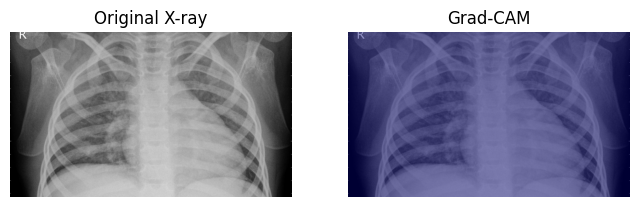

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

# ===============================
# Grad-CAM helper
# ===============================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

    def _get_activations_and_gradients(self, input_tensor):
        """
        Helper to get activations and gradients for the target layer.
        This function is called inside the generate method.
        """
        self.activations = None
        self.gradients = None

        def forward_hook(module, inp, out):
            self.activations = out.detach()

        def backward_hook(module, grad_in, grad_out):
            # grad_out is a tuple, we need the gradient with respect to the output
            self.gradients = grad_out[0].detach()

        # Register hooks just for this forward/backward pass
        forward_handle = self.target_layer.register_forward_hook(forward_hook)
        backward_handle = self.target_layer.register_backward_hook(backward_hook)

        # Perform forward pass through the relevant parts of the model
        # Need to ensure model is in training mode for gradient calculation
        self.model.train()
        img_feat = self.model.img_fc(self.model.cnn(input_tensor))

        # Restore original mode after getting activations
        self.model.eval()

        # Unregister hooks immediately after forward pass
        forward_handle.remove()
        backward_handle.remove()

        return self.activations, self.gradients


    def generate(self, input_tensor, class_idx):
        """
        input_tensor: [1,3,224,224] image tensor
        class_idx: 1 = PNEUMONIA, 0 = NORMAL
        """
        # Ensure model is in evaluation mode for the main forward pass
        self.model.eval()
        self.model.zero_grad()

        # Perform forward pass through the relevant parts of the model to get logits
        # We need to pass dummy data for tabular and text branches
        img_feat = self.model.img_fc(self.model.cnn(input_tensor))
        fused = self.model.fusion(torch.cat([
            img_feat,
            torch.zeros((1, self.model.tab_net[0].out_features), device=device),  # Use actual output size of tab_net first layer
            torch.zeros((1, self.model.lstm.hidden_size), device=device)          # Use actual hidden size of LSTM
        ], dim=1))
        logits = self.model.pneu_cls(fused)

        # Calculate gradients with respect to the target class
        score = logits[:, class_idx].squeeze()
        score.backward(retain_graph=True)

        # Get activations and gradients for the target layer
        # This part needs to be done separately to capture the gradients correctly
        # after the backward pass is complete
        # Re-run a partial forward pass to get activations at the target layer
        # and ensure gradients are captured by temporarily setting model to train mode
        self.activations = None
        self.gradients = None

        def forward_hook(module, inp, out):
            self.activations = out.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        forward_handle = self.target_layer.register_forward_hook(forward_hook)
        backward_handle = self.target_layer.register_backward_hook(backward_hook)

        # Need to set model to train mode for gradient calculation
        self.model.train()
        with torch.enable_grad():
             _ = self.model.cnn(input_tensor) # Run forward pass through CNN again

        # Restore original mode and unregister hooks
        self.model.eval()
        forward_handle.remove()
        backward_handle.remove()


        if self.gradients is None or self.activations is None:
             print("Could not get gradients or activations. Check target layer.")
             return np.zeros((self.activations.shape[-2], self.activations.shape[-1]))


        # Compute Grad-CAM
        pooled_gradients = torch.mean(self.gradients, dim=[0,2,3])  # [C]
        activations = self.activations.squeeze(0)                   # [C,H,W]

        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= heatmap.max() if heatmap.max() > 0 else 1
        return heatmap


# ===============================
# Grad-CAM visualization
# ===============================
def show_gradcam(image_path, gradcam, class_idx=1, alpha=0.4):
    """
    image_path: str → path to chest X-ray
    class_idx: 1 = Pneumonia, 0 = Normal
    alpha: overlay transparency
    """
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img_t = img_tfms(img).unsqueeze(0).to(device)

    # Generate heatmap
    heatmap = gradcam.generate(img_t, class_idx)

    # Resize heatmap to original size
    heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on original image
    img_np = np.array(img)
    # Ensure img_np is in the correct format for overlay (BGR)
    # OpenCV reads images as BGR, PIL reads as RGB. Convert PIL image to BGR for correct overlay
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    overlay = cv2.addWeighted(img_bgr, 1 - alpha, heatmap, alpha, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)


    # Show
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title("Original X-ray")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Grad-CAM")
    plt.imshow(overlay_rgb)
    plt.axis("off")
    plt.show()

# ===============================
# Example usage
# ===============================
# Target last ResNet18 block
target_layer = model.cnn.layer4[-1]
gradcam = GradCAM(model, target_layer)

# Pick a pneumonia sample from test set
sample = test_df[test_df['label']=="PNEUMONIA"].sample(1, random_state=42).iloc[0]
print("Path:", sample["image_path"], "| Label:", sample["label"])

# Show Grad-CAM
show_gradcam(sample["image_path"], gradcam, class_idx=1)

Path: /content/data/chest_xray/chest_xray/test/PNEUMONIA/person24_virus_58.jpeg | Label: PNEUMONIA


RuntimeError: cudnn RNN backward can only be called in training mode